# Cosine Decay Learning Rate

## Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Cek Data

In [2]:
train_samples = np.load('data/train_samples.npz')
ori_samples = np.load('data/ori_train.npz')

test_samples = np.load('data/test_samples.npz')


print("Keys in train_samples:", list(train_samples.keys()))
print("Keys in ori_samples:", list(ori_samples.keys()))
print("Keys in test_samples:", list(test_samples.keys()))

Keys in train_samples: ['train_images', 'train_labels']
Keys in ori_samples: ['ori_train']
Keys in test_samples: ['test_images', 'test_labels']


In [3]:
x_train = train_samples['train_images']
y_train = train_samples['train_labels']
x_ori = ori_samples['ori_train']
x_test = test_samples['test_images']
y_test = test_samples['test_labels']

# cek shape dari data train dan test
print(f"x_train shape => {x_train.shape} || x_test shape => {x_test.shape} || x_ori shape => {x_ori.shape}")

# cek type dari data train dan test
print(f"x_train type => {x_train.dtype} || x_test type => {x_test.dtype} || x_ori type => {x_ori.dtype}")

#  cek jumlah label yang ada di data train dan test
print(f"Jumlah label train : {len(np.unique(y_train))} => {np.unique(y_train)}")
print(f"Jumlah label test : {len(np.unique(y_test))} => {np.unique(y_test)}")

x_train shape => (80, 256, 256, 3) || x_test shape => (20, 256, 256, 3) || x_ori shape => (80, 256, 256, 3)
x_train type => uint8 || x_test type => uint8 || x_ori type => uint8
Jumlah label train : 4 => ['bleed' 'hole' 'missing' 'stain']
Jumlah label test : 4 => ['bleed' 'hole' 'missing' 'stain']


In [4]:
# Mapping label ke deskripsi
label_descriptions = {
	'hole': "Berlubang",
	'bleed': "Tinta Tembus",
	'stain': "Bercak",
	'missing': "Teks Hilang"
}

# Modifikasi fungsi visualisasi
def visualize_images(images, labels, indices, label_descriptions):
	num_images = len(indices)
	fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

	for i, idx in enumerate(indices):
		axes[i].imshow(images[idx].squeeze(), cmap='gray')
		axes[i].set_title(f"{label_descriptions[labels[idx]]}")
		axes[i].axis('off')

	plt.show()

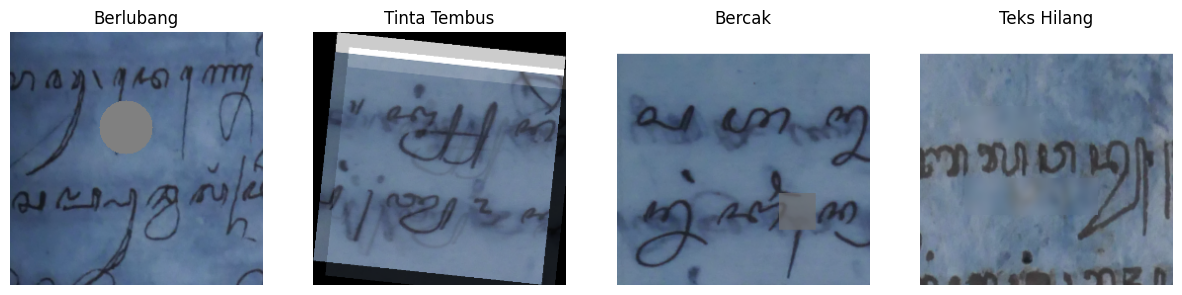

In [5]:
# index_train
train_indices = [5, 25, 45, 65]

# visualisasi data train
visualize_images(x_train, y_train, train_indices, label_descriptions)

## Normalisasi Data

In [6]:
# Fungsi normalisasi data
def normalize_data(img):
	# Mengilangkan channel warna jika perlu
	if img.shape[-1] == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	
	# dtype float32
	img = img.astype('float32')
	
	# Normalisasi data Tanh
	img = (img - 127.5) / 127.5

	# Ubah channel ke 1
	img = np.expand_dims(img, axis=-1)
	
	return img

# Normalisasi data train dan test
x_train = np.array([normalize_data(img) for img in x_train])
x_test = np.array([normalize_data(img) for img in x_test])
x_ori = np.array([normalize_data(img) for img in x_ori])

# cek shape dari data train dan test
print(f"x_train shape => {x_train.shape} || x_test shape => {x_test.shape} || x_ori shape => {x_ori.shape}")

# cek type dari data train dan test
print(f"x_train type => {x_train.dtype} || x_test type => {x_test.dtype} || x_ori type => {x_ori.dtype}")

# Cek normalisasi citra
print(f"Nilai pixel train : min => {x_train.min()} & max => {x_train.max()}")
print(f"Nilai pixel test : min => {x_test.min()} & max => {x_test.max()}")
print(f"Nilai pixel ori : min => {x_ori.min()} & max => {x_ori.max()}")

# Cek rata-rata pixel normalisasi min dan max
print(f"Rata-rata pixel train  min : {np.mean(x_train.min())}")
print(f"Rata-rata pixel train  max : {np.mean(x_train.max())}")

print(f"Rata-rata pixel ori min : {np.mean(x_ori.min())}")
print(f"Rata-rata pixel ori max : {np.mean(x_ori.max())}")

print(f"Rata-rata pixel test min : {np.mean(x_test.min())}")
print(f"Rata-rata pixel test max : {np.mean(x_test.max())}")



x_train shape => (80, 256, 256, 1) || x_test shape => (20, 256, 256, 1) || x_ori shape => (80, 256, 256, 1)
x_train type => float32 || x_test type => float32 || x_ori type => float32
Nilai pixel train : min => -1.0 & max => 1.0
Nilai pixel test : min => -0.843137264251709 & max => 1.0
Nilai pixel ori : min => -1.0 & max => 1.0
Rata-rata pixel train  min : -1.0
Rata-rata pixel train  max : 1.0
Rata-rata pixel ori min : -1.0
Rata-rata pixel ori max : 1.0
Rata-rata pixel test min : -0.843137264251709
Rata-rata pixel test max : 1.0


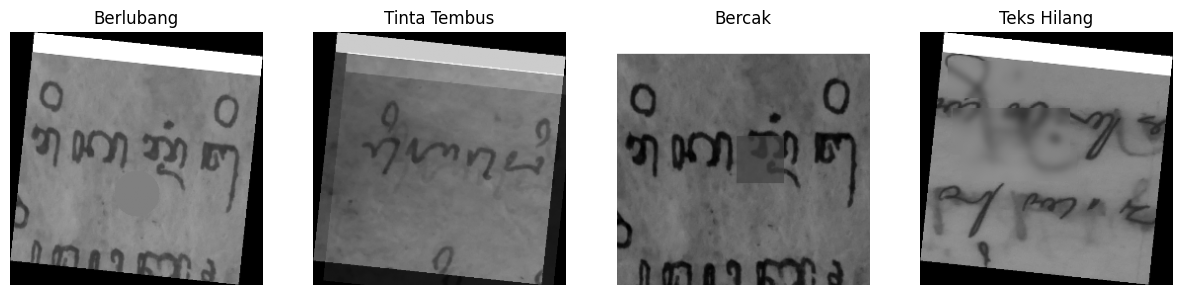

In [7]:
# index_train
train_indices = [11, 31, 51, 71]

# visualisasi data train
visualize_images(x_train, y_train, train_indices, label_descriptions)

## Train Model

### Import

In [8]:
import tensorflow as tf

# import keras
from keras.optimizers import Adam
from keras.optimizers.schedules import CosineDecay

# loss_function
from utils.loss_function import generator_loss, discriminator_loss

# import models
from models import buildGen, buildDisc

# import matrics
from utils.metrics import psnr, ssim

2.17.0


In [9]:
damaged_images = tf.data.Dataset.from_tensor_slices(x_train).batch(16)
real_images = tf.data.Dataset.from_tensor_slices(x_ori).batch(16)

# Melihat shape
for x_img, y_img in zip(damaged_images.take(1), real_images.take(1)):
	print(x_img.shape)
	print(y_img.shape)

(16, 256, 256, 1)
(16, 256, 256, 1)


### Hyperparameter

In [10]:
epochs = 50

# Cosine decay steps
batch_size = 16
batches = len(x_train) / batch_size
decay_steps = batches * epochs

# Learning rate decay
fix_lr = 0.001
cosine_lr = CosineDecay(
	initial_learning_rate=fix_lr, decay_steps=decay_steps, alpha=0.1
)

# Optimizer
optimizer_g_cosine = Adam(learning_rate=cosine_lr)
optimizer_d = Adam(learning_rate=fix_lr)

### Generator

In [11]:
# Training generator
def training_generator(generator, discriminator, real_images, damaged_images, optimizer):
	with tf.GradientTape() as tape:
		fake_images = generator(damaged_images, training=True)
		fake_output = discriminator([fake_images, damaged_images], training=False)
		gen_loss = generator_loss(real_images, fake_images, fake_output)

	gradients = tape.gradient(gen_loss, generator.trainable_variables)
	optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

	# psnr_score = psnr(real_images, fake_images)
	# ssim_score = ssim(real_images, fake_images)
	
	# print(f"Generator Loss: {gen_loss.numpy()}")
	# print(f"PSNR: {psnr_score.numpy()} || SSIM: {ssim_score.numpy()}")
	
	return gen_loss

# Build Generator
generator = buildGen()
generator.summary()

Model: "U-Net_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization        │ (None, 128, 128, 64)      │           1,088 │ input_layer[0][0]          │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 128, 128, 64)      │               0 │ spectral_normalization[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_1      │ (None, 64, 64, 128)       │         131,200 │ leaky_re_lu[0][0]          │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 128)       │             512 │ spectral_normalization_1[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_2      │ (None, 32, 32, 256)       │         524,544 │ leaky_re_lu_1[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 256)       │           1,024 │ spectral_normalization_2[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 32, 32, 256)       │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_3      │ (None, 16, 16, 512)       │       2,097,664 │ leaky_re_lu_2[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 512)       │           2,048 │ spectral_normalization_3[… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 16, 16, 512)       │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_4      │ (None, 8, 8, 512)         │       4,194,816 │ leaky_re_lu_3[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 54,756,545 (208.88 MB)

 Trainable params: 54,737,153 (208.81 MB)

 Non-trainable params: 19,392 (75.75 KB)

### Discriminator

In [12]:
# Train Discriminator
def training_discriminator(discriminator, generator, real_images, damaged_images, optimizer):
	with tf.GradientTape() as tape:
		fake_images = generator(damaged_images, training=True)
		real_output = discriminator([real_images, damaged_images], training=True)
		fake_output = discriminator([fake_images, damaged_images], training=True)
		disc_loss = discriminator_loss(real_output, fake_output)

	gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
	optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

	# print(f"Discriminator Loss: {disc_loss.numpy()}")
	return disc_loss

# Build Discriminator
discriminator = buildDisc()
discriminator.summary()

C:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "PatchGAN_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_7 (Concatenate)   │ (None, 256, 256, 2)       │               0 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_16     │ (None, 128, 128, 64)      │           2,112 │ concatenate_7[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU)     │ (None, 128, 128, 64)      │               0 │ spectral_normalization_16… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_17     │ (None, 64, 64, 128)       │         131,200 │ leaky_re_lu_8[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 64, 64, 128)       │             512 │ spectral_normalization_17… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ batch_normalization_14[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_18     │ (None, 32, 32, 256)       │         524,544 │ leaky_re_lu_9[0][0]        │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 32, 32, 256)       │           1,024 │ spectral_normalization_18… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_10 (LeakyReLU)    │ (None, 32, 32, 256)       │               0 │ batch_normalization_15[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spectral_normalization_19     │ (None, 16, 16, 512)       │       2,097,664 │ leaky_re_lu_10[0][0]       │
│ (SpectralNormalization)       │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 16, 16, 512)       │           2,048 │ spectral_normalization_19… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,095,618 (11.81 MB)

 Trainable params: 3,092,865 (11.80 MB)

 Non-trainable params: 2,753 (10.75 KB)

### Train Loop

In [13]:
from tqdm import tqdm
import time

In [14]:
def visualize_images(damaged_images, real_images, generated_images, num_samples=5):
	plt.figure(figsize=(15, 5))
	for i in range(num_samples):
		# Damaged
		plt.subplot(3, num_samples, i + 1)
		plt.imshow(np.squeeze(damaged_images[i]), cmap='gray')
		plt.title("Damaged")
		plt.axis("off")

		# Real
		plt.subplot(3, num_samples, i + 1 + num_samples)
		plt.imshow(np.squeeze(real_images[i]), cmap='gray')
		plt.title("Real")
		plt.axis("off")

		# Generated
		plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
		plt.imshow(np.squeeze(generated_images[i]), cmap='gray')
		plt.title("Generated")
		plt.axis("off")
	plt.tight_layout()
	plt.show()


def plot_loss(generator_losses, discriminator_losses):
	plt.figure(figsize=(10, 5))
	plt.plot(generator_losses, label='Generator Loss', color='blue')
	plt.plot(discriminator_losses, label='Discriminator Loss', color='red')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Losses')
	plt.legend()
	plt.show()

In [15]:
def train_model(generator, discriminator, damaged_dataset, real_dataset, epochs):
	# Gabungkan dataset menjadi satu
	train_dataset = tf.data.Dataset.zip((damaged_dataset, real_dataset))

	for epoch in range(epochs):
		start_time = time.time()
		gen_loss_list = []
		disc_loss_list = []

		with tqdm(total=batches , desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
			for damaged_batch, real_batch in train_dataset:
				# Latih discriminator
				disc_loss = training_discriminator(discriminator, generator, real_batch, damaged_batch, optimizer_d)
				# Latih generator
				gen_loss = training_generator(generator, discriminator, real_batch, damaged_batch, optimizer_g_cosine)

				gen_loss_list.append(gen_loss.numpy())
				disc_loss_list.append(disc_loss.numpy())

				# Update progress bar
				pbar.set_postfix(Gen_Loss=gen_loss.numpy(), Disc_Loss=disc_loss.numpy())
				pbar.update(1)

		# Hitung waktu epoch dan rata-rata loss
		epoch_duration = time.time() - start_time
		avg_gen_loss = sum(gen_loss_list) / len(gen_loss_list)
		avg_disc_loss = sum(disc_loss_list) / len(disc_loss_list)

		print(f"Epoch {epoch+1}/{epochs} completed in {epoch_duration:.2f}s")
		print(f"Average Generator Loss: {avg_gen_loss:.4f}, Average Discriminator Loss: {avg_disc_loss:.4f}\n")

train_model(generator, discriminator, damaged_images, real_images, epochs)

Epoch 1/50:   0%|                                                                                                                                     | 0/5.0 [00:00<?, ?batch/s]C:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [08:07<00:00, 97.55s/batch, Disc_Loss=1.47, Gen_Loss=11.3]


Epoch 1/50 completed in 487.80s
Average Generator Loss: 28.7051, Average Discriminator Loss: 2.3061



Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:54<00:00, 82.82s/batch, Disc_Loss=1.39, Gen_Loss=7.78]


Epoch 2/50 completed in 414.13s
Average Generator Loss: 9.7821, Average Discriminator Loss: 1.4490



Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:27<00:00, 65.59s/batch, Disc_Loss=1.39, Gen_Loss=6.31]


Epoch 3/50 completed in 327.98s
Average Generator Loss: 7.3071, Average Discriminator Loss: 1.4001



Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [07:28<00:00, 89.67s/batch, Disc_Loss=1.38, Gen_Loss=5.25]


Epoch 4/50 completed in 448.36s
Average Generator Loss: 6.0822, Average Discriminator Loss: 1.3893



Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:44<00:00, 68.81s/batch, Disc_Loss=1.38, Gen_Loss=4.33]


Epoch 5/50 completed in 344.08s
Average Generator Loss: 5.2377, Average Discriminator Loss: 1.3819



Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [04:50<00:00, 58.10s/batch, Disc_Loss=1.37, Gen_Loss=4.06]


Epoch 6/50 completed in 290.54s
Average Generator Loss: 4.6877, Average Discriminator Loss: 1.3705



Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:09<00:00, 61.95s/batch, Disc_Loss=1.38, Gen_Loss=3.87]


Epoch 7/50 completed in 309.86s
Average Generator Loss: 4.4414, Average Discriminator Loss: 1.3641



Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:56<00:00, 83.26s/batch, Disc_Loss=1.44, Gen_Loss=3.6]


Epoch 8/50 completed in 416.32s
Average Generator Loss: 4.1500, Average Discriminator Loss: 1.3717



Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:30<00:00, 78.11s/batch, Disc_Loss=1.39, Gen_Loss=3.44]


Epoch 9/50 completed in 390.71s
Average Generator Loss: 3.9380, Average Discriminator Loss: 1.3773



Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:42<00:00, 80.40s/batch, Disc_Loss=1.35, Gen_Loss=3.23]


Epoch 10/50 completed in 402.06s
Average Generator Loss: 3.7633, Average Discriminator Loss: 1.3409



Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [07:03<00:00, 84.64s/batch, Disc_Loss=1.37, Gen_Loss=3.04]


Epoch 11/50 completed in 423.28s
Average Generator Loss: 3.5574, Average Discriminator Loss: 1.3182



Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:38<00:00, 79.68s/batch, Disc_Loss=1.44, Gen_Loss=2.9]


Epoch 12/50 completed in 399.38s
Average Generator Loss: 3.3783, Average Discriminator Loss: 1.3277



Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [07:17<00:00, 87.52s/batch, Disc_Loss=1.33, Gen_Loss=2.78]


Epoch 13/50 completed in 437.70s
Average Generator Loss: 3.2665, Average Discriminator Loss: 1.3067



Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [04:57<00:00, 59.43s/batch, Disc_Loss=1.43, Gen_Loss=2.87]


Epoch 14/50 completed in 297.18s
Average Generator Loss: 3.2080, Average Discriminator Loss: 1.3236



Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:25<00:00, 77.01s/batch, Disc_Loss=1.33, Gen_Loss=2.94]


Epoch 15/50 completed in 385.07s
Average Generator Loss: 3.3599, Average Discriminator Loss: 1.2897



Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:14<00:00, 74.81s/batch, Disc_Loss=1.37, Gen_Loss=2.91]


Epoch 16/50 completed in 374.09s
Average Generator Loss: 3.3329, Average Discriminator Loss: 1.2803



Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:27<00:00, 65.49s/batch, Disc_Loss=1.43, Gen_Loss=2.74]


Epoch 17/50 completed in 327.51s
Average Generator Loss: 3.2036, Average Discriminator Loss: 1.2843



Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:30<00:00, 66.08s/batch, Disc_Loss=1.47, Gen_Loss=2.59]


Epoch 18/50 completed in 330.43s
Average Generator Loss: 3.0027, Average Discriminator Loss: 1.2525



Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:11<00:00, 74.31s/batch, Disc_Loss=1.37, Gen_Loss=2.65]


Epoch 19/50 completed in 371.60s
Average Generator Loss: 3.1272, Average Discriminator Loss: 1.3319



Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [07:09<00:00, 85.96s/batch, Disc_Loss=1.43, Gen_Loss=2.52]


Epoch 20/50 completed in 429.86s
Average Generator Loss: 3.0130, Average Discriminator Loss: 1.3383



Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:07<00:00, 73.45s/batch, Disc_Loss=1.41, Gen_Loss=2.53]


Epoch 21/50 completed in 367.32s
Average Generator Loss: 2.9427, Average Discriminator Loss: 1.3078



Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [07:39<00:00, 91.82s/batch, Disc_Loss=1.48, Gen_Loss=2.84]


Epoch 22/50 completed in 459.24s
Average Generator Loss: 3.0323, Average Discriminator Loss: 1.2362



Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [06:25<00:00, 77.04s/batch, Disc_Loss=1.28, Gen_Loss=2.78]


Epoch 23/50 completed in 385.24s
Average Generator Loss: 3.2654, Average Discriminator Loss: 1.2062



Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:25<00:00, 65.04s/batch, Disc_Loss=1.36, Gen_Loss=2.98]


Epoch 24/50 completed in 325.25s
Average Generator Loss: 3.0191, Average Discriminator Loss: 1.2405



Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [04:30<00:00, 54.08s/batch, Disc_Loss=1.4, Gen_Loss=2.86]


Epoch 25/50 completed in 270.42s
Average Generator Loss: 3.4299, Average Discriminator Loss: 1.3826



Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [05:08<00:00, 61.73s/batch, Disc_Loss=1.32, Gen_Loss=2.71]


Epoch 26/50 completed in 308.67s
Average Generator Loss: 3.2196, Average Discriminator Loss: 1.2498



Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [09:17<00:00, 111.58s/batch, Disc_Loss=1.35, Gen_Loss=2.5]


Epoch 27/50 completed in 557.92s
Average Generator Loss: 3.0000, Average Discriminator Loss: 1.2817



Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5.0 [08:32<00:00, 102.58s/batch, Disc_Loss=1.39, Gen_Loss=2.42]


Epoch 28/50 completed in 512.97s
Average Generator Loss: 2.8753, Average Discriminator Loss: 1.3230



Epoch 29/50:   0%|                                                                                                                                    | 0/5.0 [00:02<?, ?batch/s]


KeyboardInterrupt: 

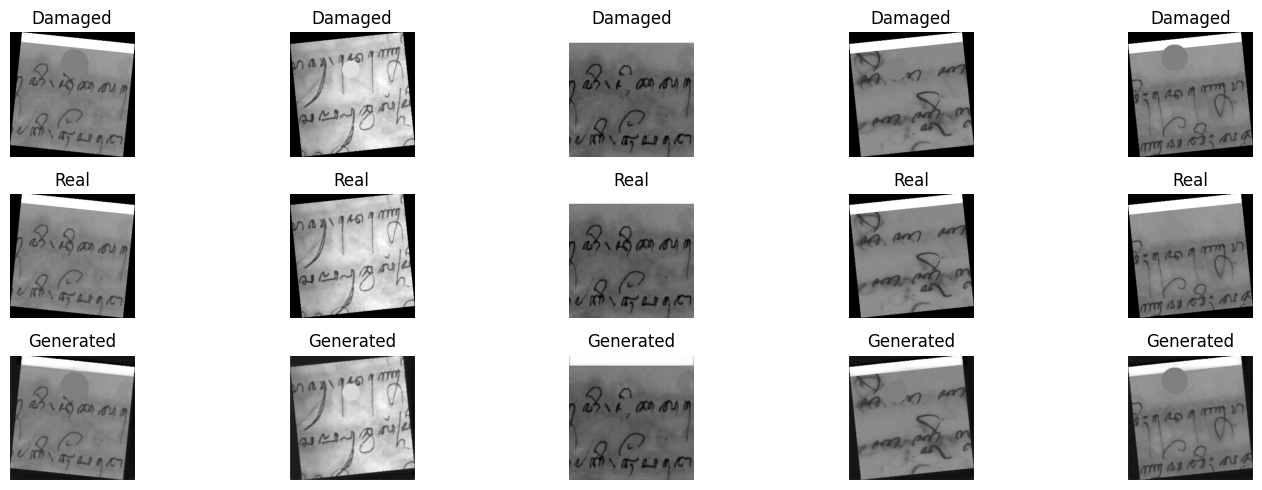

In [16]:
visualize_images(x_train, x_ori, generator(x_train[:5]), num_samples=5)